## Testing out different ML algorithms

Malin: Random Forest, Neural Network, BART, GXBoost

array([[<Axes: xlabel='wind_speed', ylabel='wind_speed'>,
        <Axes: xlabel='max_wind_speed', ylabel='wind_speed'>,
        <Axes: xlabel='R_SW_in', ylabel='wind_speed'>,
        <Axes: xlabel='R_net', ylabel='wind_speed'>,
        <Axes: xlabel='H_qc0', ylabel='wind_speed'>,
        <Axes: xlabel='precip_int_h_D', ylabel='wind_speed'>,
        <Axes: xlabel='albedo', ylabel='wind_speed'>,
        <Axes: xlabel='air_temperature', ylabel='wind_speed'>,
        <Axes: xlabel='wind_dir', ylabel='wind_speed'>,
        <Axes: xlabel='specific_humidity', ylabel='wind_speed'>,
        <Axes: xlabel='air_pressure', ylabel='wind_speed'>,
        <Axes: xlabel='hour', ylabel='wind_speed'>,
        <Axes: xlabel='doy', ylabel='wind_speed'>],
       [<Axes: xlabel='wind_speed', ylabel='max_wind_speed'>,
        <Axes: xlabel='max_wind_speed', ylabel='max_wind_speed'>,
        <Axes: xlabel='R_SW_in', ylabel='max_wind_speed'>,
        <Axes: xlabel='R_net', ylabel='max_wind_speed'>,
        <Ax

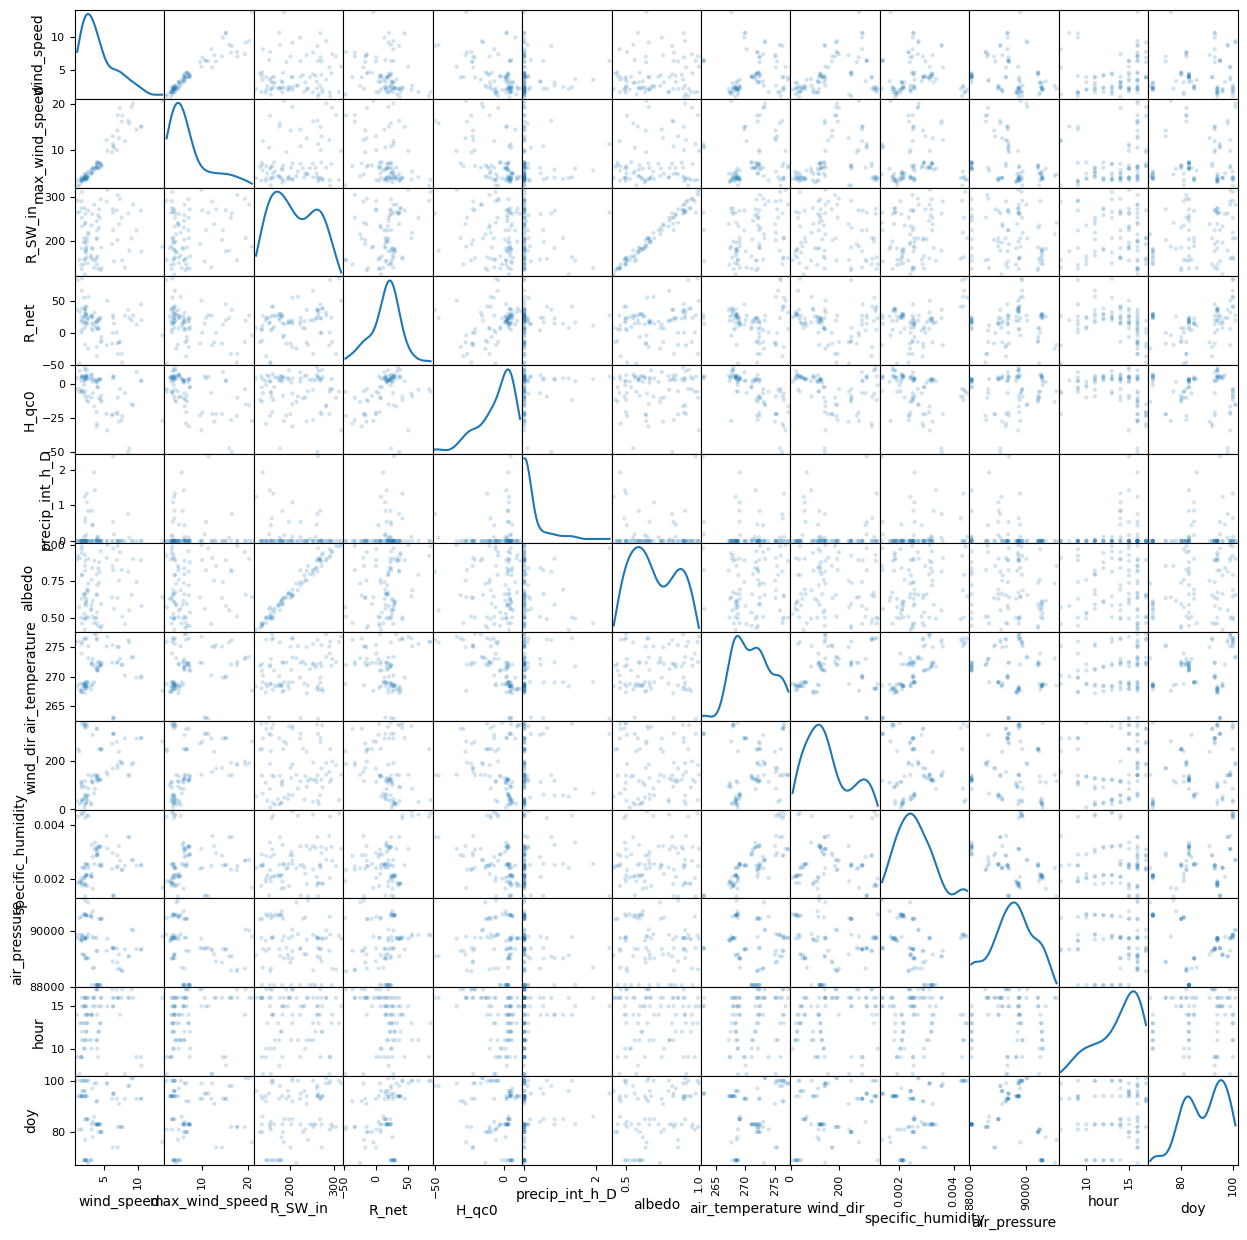

In [23]:
# Data handling / plotting:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # data splitting for training and evaluating the models
from sklearn.preprocessing import StandardScaler # data normalisation

#-------------------------------------------------------------------------------

# Random Forest part:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score  # Import regression metrics
from sklearn.model_selection import GridSearchCV # Import GridSearchCV for hyperparameter tuning

#-------------------------------------------------------------------------------

# Neural Network part:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

#-------------------------------------------------------------------------------

# Load and prepare the data
df = pd.read_csv("../data/Tuddal_data.csv", na_values=np.nan)
#df = pd.read_csv("/home/mlahlbac/COURSES/Geophysical_data_science/Tuddal_data.csv", na_values=np.nan)

# Calculate albedo -- remove values > 1, < 0.3
df["albedo"] = df['R_SW_in'] / df['R_LW_out_corr']
df["albedo"] = df["albedo"].apply(lambda x: x if x < 1 and x > 0.4 else np.nan)

# Get R_net:
df['R_net']   = df['SW_net'] + df['LW_net']

# Get the DOY from the timestamp:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["doy"] = df["timestamp"].dt.dayofyear

# Get the hour of the day from the timestamp:
df["hour"] = df["timestamp"].dt.hour


# Define features and target variable
features = [
    "wind_speed", 
    "max_wind_speed", 
    "R_SW_in",
    "R_net", 
    "H_qc0",
    "precip_int_h_D", 
    "albedo",
    "air_temperature", 
    "wind_dir", 
 #   "VPD",
 #   "u*",
    "specific_humidity",
    "air_pressure", 
    "hour",
    "doy"
  #  "FC1DRIFTsum_99_99_1_1_1", 
   # "FC2DRIFTsum_99_99_1_1_1"
    ]

df = df.dropna(subset=['LE_qc0']) 
df = df.dropna(subset=features) 

y = df["LE_qc0"]
X = df[features]

pd.plotting.scatter_matrix(X, alpha=0.2, figsize=(15, 15), diagonal='kde')

/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_5763/1243593496.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-8.66025404e-01  5.00000000e-01  5.00000000e-01  2.58819045e-01
  2.58819045e-01  1.22464680e-16  1.22464680e-16 -2.58819045e-01
 -2.58819045e-01 -5.00000000e-01 -8.66025404e-01 -8.66025404e-01
 -8.66025404e-01 -8.66025404e-01 -7.07106781e-01 -7.07106781e-01
 -7.07106781e-01 -8.66025404e-01 -8.66025404e-01  9.65925826e-01
  7.07106781e-01  5.00000000e-01 -5.00000000e-01 -8.66025404e-01
 -8.66025404e-01 -9.65925826e-01  7.07106781e-01  5.00000000e-01
  2.58819045e-01  2.58819045e-01  1.22464680e-16  1.22464680e-16
 -2.58819045e-01 -2.58819045e-01 -5.00000000e-01 -5.00000000e-01
 -7.07106781e-01 -8.66025404e-01 -5.00000000e-01 -

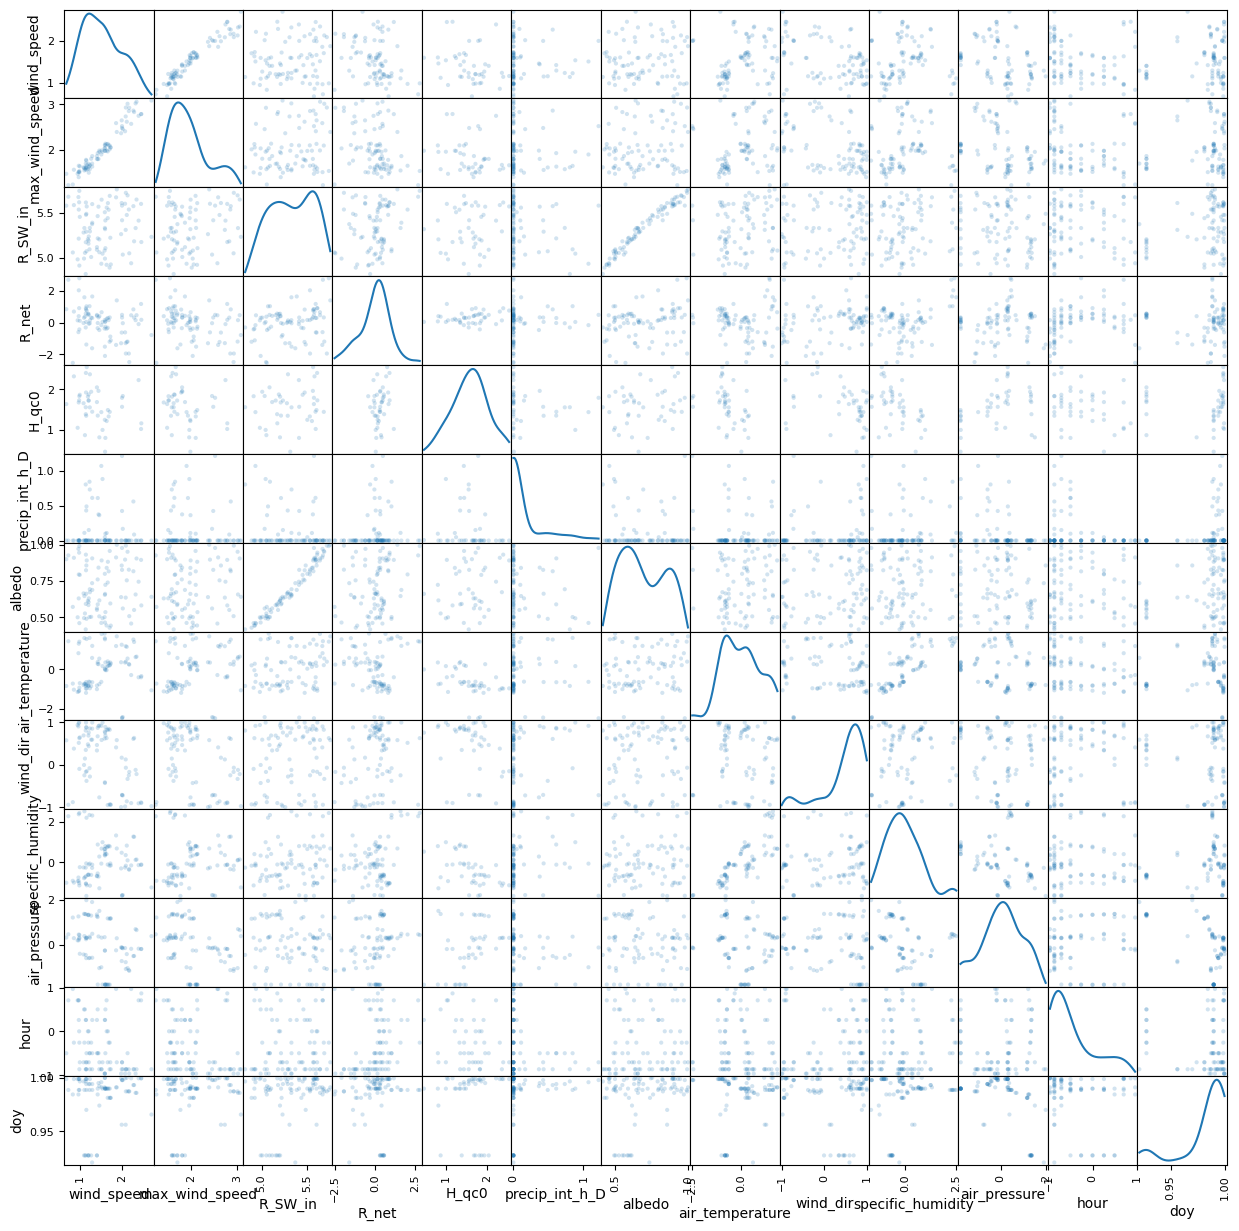

In [ ]:
# Normalise (standardise) the data before training the model
# Based on the scatter matrix, we can see that air temp and humidity are normally distributed, air pressure as well sort of.
# Wind speed, max wind speed and R_SW_in are skewed, and should be log scaled.
# wind direction, doy and hour are cyclic, and should be transformed to sin/cos.

# albedo is already scaled 0-1, so no need to scale it.

# Normalise the data: z-score standardisation for normal dist. data:
scaler = StandardScaler()
X.loc[:, 'air_temperature'] = scaler.fit_transform(X['air_temperature'].values.reshape(-1, 1))
X.loc[:, 'specific_humidity'] = scaler.fit_transform(X['specific_humidity'].values.reshape(-1, 1))
X.loc[:, 'air_pressure'] = scaler.fit_transform(X['air_pressure'].values.reshape(-1, 1))
X.loc[:, 'R_net'] = scaler.fit_transform(X['R_net'].values.reshape(-1, 1))

# Log scaling for skewed data:
X.loc[:, 'wind_speed'] = np.log(X['wind_speed'] + 1)
X.loc[:, 'max_wind_speed'] = np.log(X['max_wind_speed'] + 1)
X.loc[:, 'R_SW_in'] = np.log(X['R_SW_in'] + 1)
X.loc[:, 'precip_int_h_D'] = np.log(X['precip_int_h_D'] + 1)
X.loc[:, 'H_qc0'] = np.log(X['H_qc0'] + 1)

# Cyclic encoding for hour and doy:
X.loc[:, 'hour'] = np.sin(2 * np.pi * X['hour'] / 24)
X.loc[:, 'doy'] = np.sin(2 * np.pi * X['doy'] / 365)
X.loc[:, 'wind_dir'] = np.sin(2 * np.pi * X['wind_dir'] / 360)

pd.plotting.scatter_matrix(X, alpha=0.2, figsize=(15, 15), diagonal='kde')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


## Starting out with Random Forest

Below is 1) Default settings, and 2) Testing out a grid with parameters to evaluate the model combo with the highest R². 

The 1) generated quite high R² values already. 

In [25]:
# Initialize and train the RandomForestRegressor
clf = RandomForestRegressor(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Performance statistics:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2:.2f}')



Mean Squared Error: 19.36
R^2 Score: 0.86


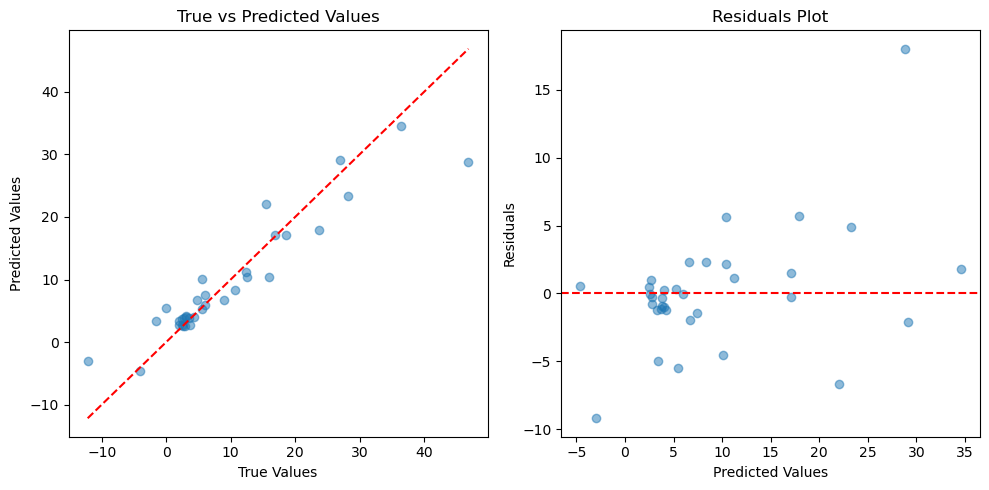

In [26]:
# Plotting True vs Predicted values
plt.figure(figsize=(10, 5))

# Scatter plot for true vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")

plt.tight_layout()
plt.show()


In [27]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='r2', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best R^2 Score: {grid_search.best_score_:.2f}')

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test R^2 Score: {r2:.2f}')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

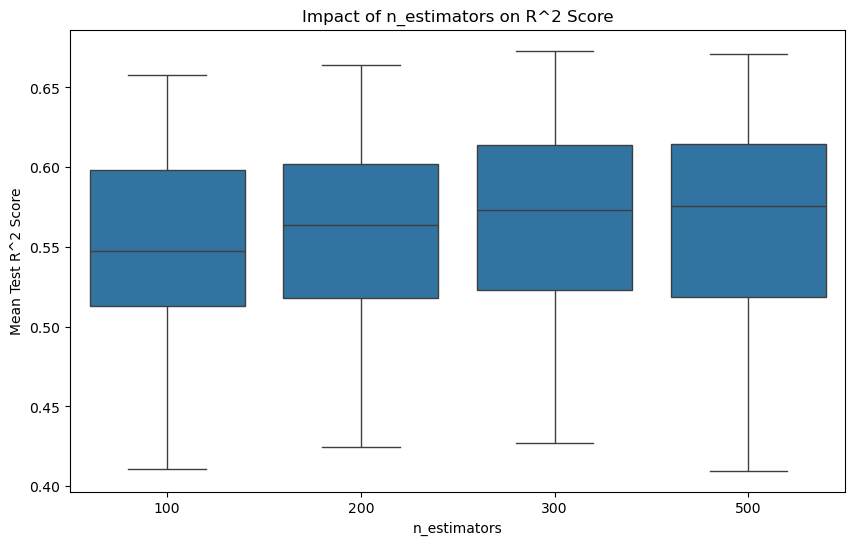

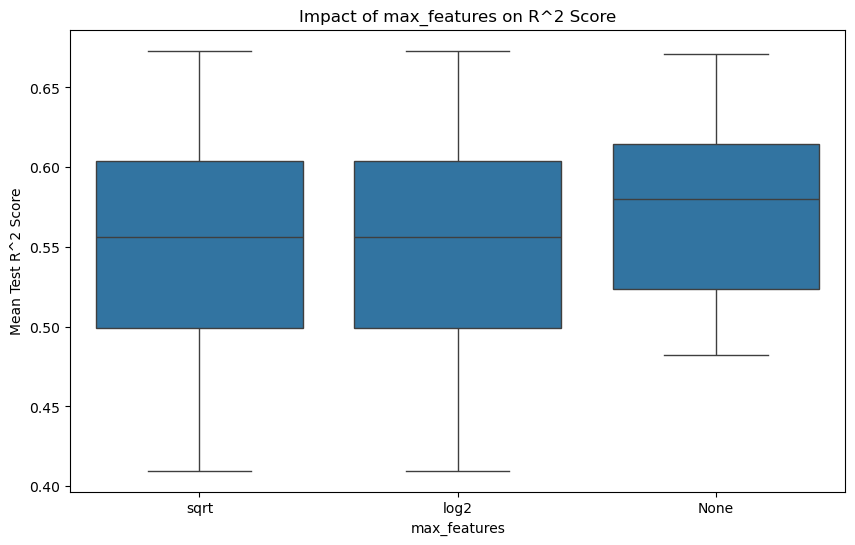

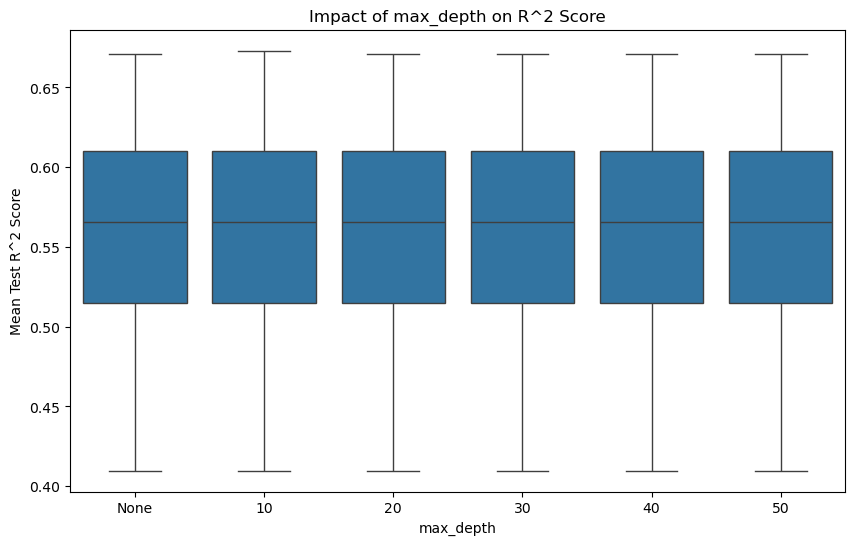

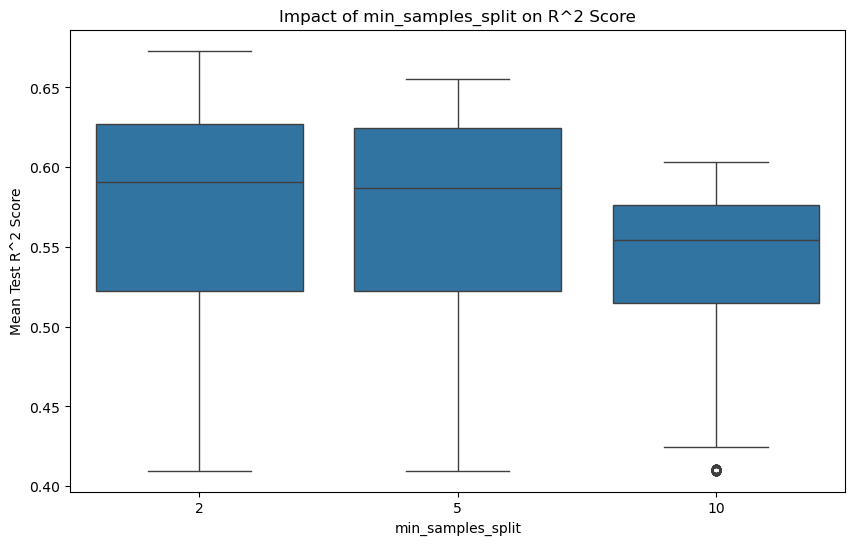

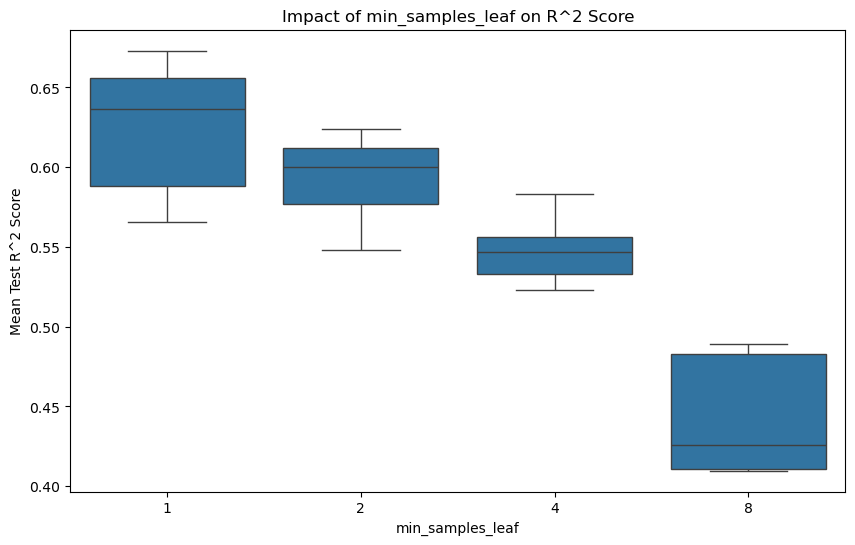

In [28]:
# Convert the results to a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Convert None values to a string representation for plotting
results['param_max_features'] = results['param_max_features'].astype(str)
results['param_max_depth'] = results['param_max_depth'].astype(str)


# Plot the impact of each parameter
for param in param_grid.keys():
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=f'param_{param}', y='mean_test_score', data=results)
    plt.title(f'Impact of {param} on R^2 Score')
    plt.xlabel(param)
    plt.ylabel('Mean Test R^2 Score')
    plt.show()

## Neural Network

In [29]:
# Define the hyperparameters:
units = 32 # Number of units in the hidden layer, i.e., the number of neurons. 
activation = 'tanh' # Activation function for the hidden layer. Can choose from 'relu', 'tanh', 'sigmoid', etc.
optimizer = 'adam' # can choose from 'adam', 'sgd', 'rmsprop', etc.
epochs = 50 # this is the number of times the model will be trained on the data
batch_size = 30 # the number of samples that will be used in each training iteration

# FOund in CV run:
#Best Parameters: {'activation': 'tanh', 'batch_size': 30, 'epochs': 50, 'units': 32}

# Build the neural network model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Setting input shape
model.add(Dense(
    units,
    activation=activation,
    kernel_initializer="uniform"
))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting

# Add more layers if necessary
model.add(Dense(units, activation=activation))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(1))  # Output layer for regression (single output)

# Print a summary of the model
model.summary()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['root_mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: 

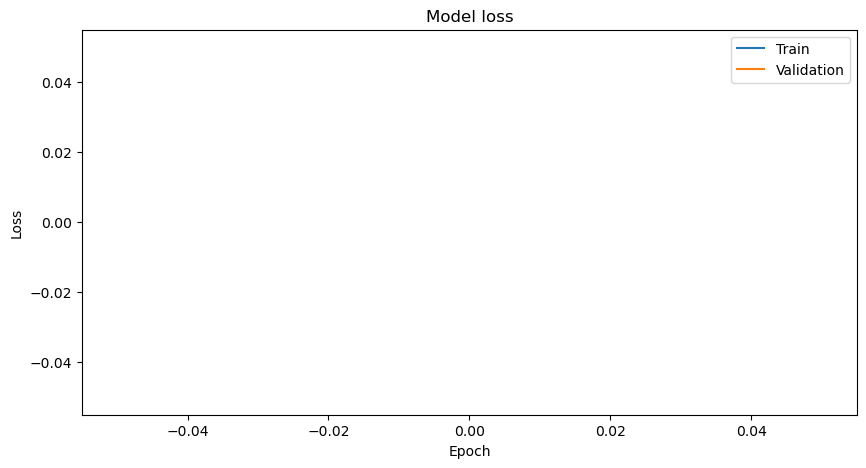

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f9b59fc56c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


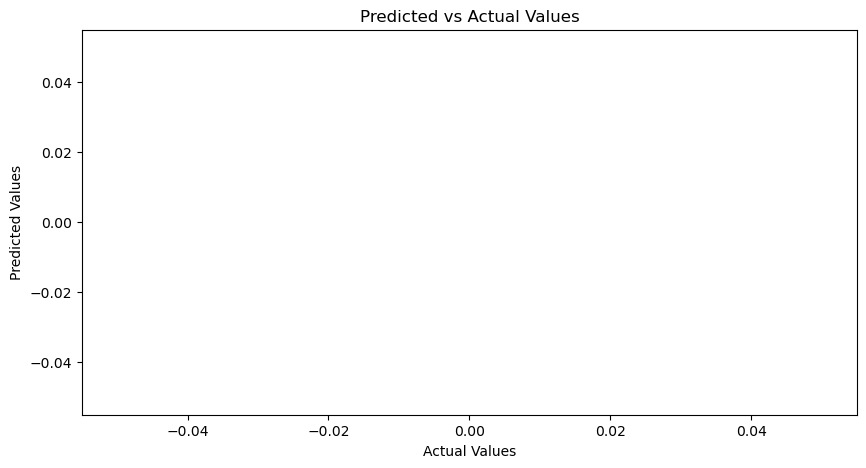

/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

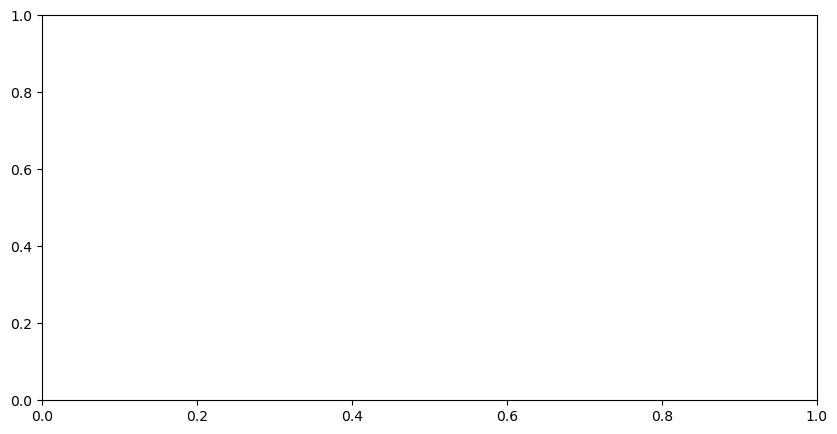

In [30]:
# PLOT RESULTS:

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Calculate residuals
residuals = y_test - y_pred.reshape(-1)

# Histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals to check for randomness (should be centered around 0)
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r')
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [ ]:

################################################
# FEATURE IMPORTANCE -- PERMUTATION IMPORTANCE #

import numpy as np
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Assuming you have trained your model and split your data into X_train, X_test, y_train, y_test

# Evaluating feature importance using permutation importance
# Neural networks from Keras can be wrapped in a sklearn-compatible way using KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor

def create_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu', kernel_initializer='uniform'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

keras_model = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0)
keras_model.fit(X_train, y_train)

# Compute permutation feature importance
result = permutation_importance(keras_model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

# Summarize feature importance
sorted_idx = result.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title("Permutation Feature Importance")
plt.xlabel("Mean Decrease in Impurity")
plt.show()


In [ ]:
# Create a function to build the model
def create_model(units=64, activation='relu'):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(units, activation=activation, kernel_initializer='uniform'),
        Dropout(0.2),
        Dense(units, activation=activation),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Wrap the Keras model in a scikit-learn compatible model
keras_model = KerasRegressor(build_fn=create_model, verbose=0,activation='relu', units=64)

# Create a matrix for hyperparameter tuning
param_grid = {
    'units': [32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'batch_size': [10, 20, 30],
    'epochs': [50, 100, 200]
}

# Create the GridSearchCV object 
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Score: {grid_result.best_score_}')

# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
loss, mae = best_model.model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Plot the impact of each parameter
results = pd.DataFrame(grid_result.cv_results_)
for param in param_grid.keys():
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=f'param_{param}', y='mean_test_score', data=results)
    plt.title(f'Impact of {param} on R^2 Score')
    plt.xlabel(param)
    plt.ylabel('Mean Test R^2 Score')
    plt.show()

Fitting 3 folds for each of 81 candidates, totalling 243 fits


2024-11-13 23:33:36.844184: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:33:36.850902: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:33:36.870992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 23:33:36.883064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:33:36.884810: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:33:36.890133: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:33:36.891093: I external/local_xla/x

[CV] END activation=relu, batch_size=10, epochs=50, units=32; total time=   9.7s
[CV] END activation=relu, batch_size=10, epochs=50, units=128; total time=  10.2s
[CV] END activation=relu, batch_size=10, epochs=50, units=64; total time=  10.5s
[CV] END activation=relu, batch_size=10, epochs=50, units=64; total time=  10.5s
[CV] END activation=relu, batch_size=10, epochs=50, units=32; total time=  10.5s
[CV] END activation=relu, batch_size=10, epochs=50, units=64; total time=  10.5s
[CV] END activation=relu, batch_size=10, epochs=50, units=32; total time=  10.7s
[CV] END activation=relu, batch_size=10, epochs=50, units=128; total time=  11.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-13 23:33:55.020906: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:33:55.027207: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:33:55.045748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731537235.070749  488566 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731537235.077536  488

[CV] END activation=relu, batch_size=10, epochs=50, units=128; total time=  10.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=32; total time=  15.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=32; total time=  16.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=64; total time=  14.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=32; total time=  16.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=64; total time=  16.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=128; total time=  14.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=64; total time=  16.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=128; total time=  15.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=100, units=128; total time=  15.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=200, units=32; total time=  26.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=200, units=32; total time=  29.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=200, units=64; total time=  28.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=200, units=32; total time=  30.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=200, units=64; total time=  31.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=200, units=64; total time=  32.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=10, epochs=200, units=128; total time=  30.8s
[CV] END activation=relu, batch_size=20, epochs=50, units=32; total time=   9.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=50, units=32; total time=   8.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=50, units=32; total time=   9.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=50, units=64; total time=   7.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=50, units=64; total time=   7.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=50, units=64; total time=   6.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=50, units=128; total time=   7.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=50, units=128; total time=   7.5s
[CV] END activation=relu, batch_size=10, epochs=200, units=128; total time=  34.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=50, units=128; total time=   7.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=100, units=32; total time=  12.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=100, units=32; total time=  10.8s
[CV] END activation=relu, batch_size=10, epochs=200, units=128; total time=  31.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=100, units=32; total time=  10.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=100, units=64; total time=  10.4s
[CV] END activation=relu, batch_size=20, epochs=100, units=64; total time=  10.9s
[CV] END activation=relu, batch_size=20, epochs=100, units=64; total time=  10.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=100, units=128; total time=  13.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=100, units=128; total time=  13.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=100, units=128; total time=  13.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=200, units=32; total time=  22.9s
[CV] END activation=relu, batch_size=20, epochs=200, units=32; total time=  22.0s
[CV] END activation=relu, batch_size=20, epochs=200, units=64; total time=  22.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=200, units=64; total time=  22.7s
[CV] END activation=relu, batch_size=20, epochs=200, units=32; total time=  23.4s
[CV] END activation=relu, batch_size=20, epochs=200, units=64; total time=  23.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=50, units=32; total time=   5.6s
[CV] END activation=relu, batch_size=30, epochs=50, units=64; total time=   5.9s
[CV] END activation=relu, batch_size=30, epochs=50, units=32; total time=   6.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=50, units=32; total time=   6.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=50, units=64; total time=   6.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=50, units=64; total time=   6.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=50, units=128; total time=   6.1s
[CV] END activation=relu, batch_size=20, epochs=200, units=128; total time=  23.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=200, units=128; total time=  23.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=50, units=128; total time=   7.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=50, units=128; total time=   7.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=32; total time=   9.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=20, epochs=200, units=128; total time=  22.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=64; total time=  10.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=32; total time=  12.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=32; total time=  12.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=64; total time=  12.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=64; total time=  12.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=128; total time=  13.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=128; total time=  14.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=100, units=128; total time=  13.2s
[CV] END activation=relu, batch_size=30, epochs=200, units=32; total time=  18.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=200, units=64; total time=  17.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=200, units=32; total time=  18.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=200, units=32; total time=  19.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=200, units=64; total time=  18.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=200, units=64; total time=  18.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=200, units=128; total time=  15.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=50, units=32; total time=   8.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=50, units=32; total time=   8.7s
[CV] END activation=tanh, batch_size=10, epochs=50, units=32; total time=   9.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=50, units=64; total time=   8.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=50, units=64; total time=   8.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=relu, batch_size=30, epochs=200, units=128; total time=  19.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=50, units=128; total time=   8.5s
[CV] END activation=tanh, batch_size=10, epochs=50, units=64; total time=   9.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=50, units=128; total time=   8.9s
[CV] END activation=relu, batch_size=30, epochs=200, units=128; total time=  20.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=50, units=128; total time=   9.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=32; total time=  14.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=32; total time=  15.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=32; total time=  16.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=64; total time=  14.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=64; total time=  15.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=128; total time=  15.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=64; total time=  16.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=128; total time=  17.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=100, units=128; total time=  18.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=200, units=32; total time=  30.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=200, units=32; total time=  33.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=200, units=64; total time=  30.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=200, units=32; total time=  33.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=200, units=128; total time=  30.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=200, units=64; total time=  32.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=200, units=64; total time=  32.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=50, units=32; total time=   7.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=50, units=32; total time=   7.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=50, units=32; total time=   7.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=10, epochs=200, units=128; total time=  30.6s
[CV] END activation=tanh, batch_size=20, epochs=50, units=64; total time=   7.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=50, units=64; total time=   7.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=50, units=64; total time=   8.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=50, units=128; total time=   8.1s
[CV] END activation=tanh, batch_size=20, epochs=50, units=128; total time=   7.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=50, units=128; total time=   7.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=100, units=32; total time=  11.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=100, units=32; total time=  12.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=100, units=32; total time=  12.0s
[CV] END activation=tanh, batch_size=10, epochs=200, units=128; total time=  28.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=100, units=64; total time=  13.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=100, units=64; total time=  12.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=100, units=64; total time=  13.0s
[CV] END activation=tanh, batch_size=20, epochs=100, units=128; total time=  12.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=100, units=128; total time=  12.2s
[CV] END activation=tanh, batch_size=20, epochs=100, units=128; total time=  12.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=200, units=32; total time=  19.4s
[CV] END activation=tanh, batch_size=20, epochs=200, units=32; total time=  19.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=200, units=32; total time=  20.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=200, units=64; total time=  20.8s
[CV] END activation=tanh, batch_size=20, epochs=200, units=64; total time=  20.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=50, units=32; total time=   7.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=200, units=64; total time=  22.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=50, units=32; total time=   9.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=50, units=32; total time=   9.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=50, units=64; total time=   9.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=200, units=128; total time=  24.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=50, units=64; total time=  10.7s
[CV] END activation=tanh, batch_size=30, epochs=50, units=64; total time=  10.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=200, units=128; total time=  26.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=50, units=128; total time=   8.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=50, units=128; total time=   8.9s
[CV] END activation=tanh, batch_size=30, epochs=50, units=128; total time=   8.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=100, units=32; total time=   9.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=20, epochs=200, units=128; total time=  27.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=100, units=64; total time=   9.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=100, units=32; total time=  11.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=100, units=32; total time=  11.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=100, units=64; total time=  10.8s
[CV] END activation=tanh, batch_size=30, epochs=100, units=128; total time=   8.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=100, units=64; total time=  11.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=100, units=128; total time=  11.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=100, units=128; total time=  11.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=200, units=32; total time=  16.0s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=200, units=32; total time=  18.3s
[CV] END activation=tanh, batch_size=30, epochs=200, units=64; total time=  15.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=200, units=32; total time=  18.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=200, units=64; total time=  18.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=200, units=128; total time=  16.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=200, units=64; total time=  19.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=50, units=32; total time=   7.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=50, units=32; total time=   9.1s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=50, units=32; total time=   8.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=200, units=128; total time=  20.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=50, units=64; total time=   9.4s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=tanh, batch_size=30, epochs=200, units=128; total time=  22.9s
[CV] END activation=sigmoid, batch_size=10, epochs=50, units=64; total time=  12.9s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=50, units=64; total time=  12.7s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=50, units=128; total time=  14.2s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=50, units=128; total time=  17.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=50, units=128; total time=  17.5s
[CV] END activation=sigmoid, batch_size=10, epochs=100, units=32; total time=  36.3s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=100, units=64; total time=  31.5s
[CV] END activation=sigmoid, batch_size=10, epochs=100, units=32; total time=  37.8s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=100, units=32; total time=  36.5s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=100, units=64; total time=  36.6s


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END activation=sigmoid, batch_size=10, epochs=100, units=64; total time= 5.8min


/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


## BART